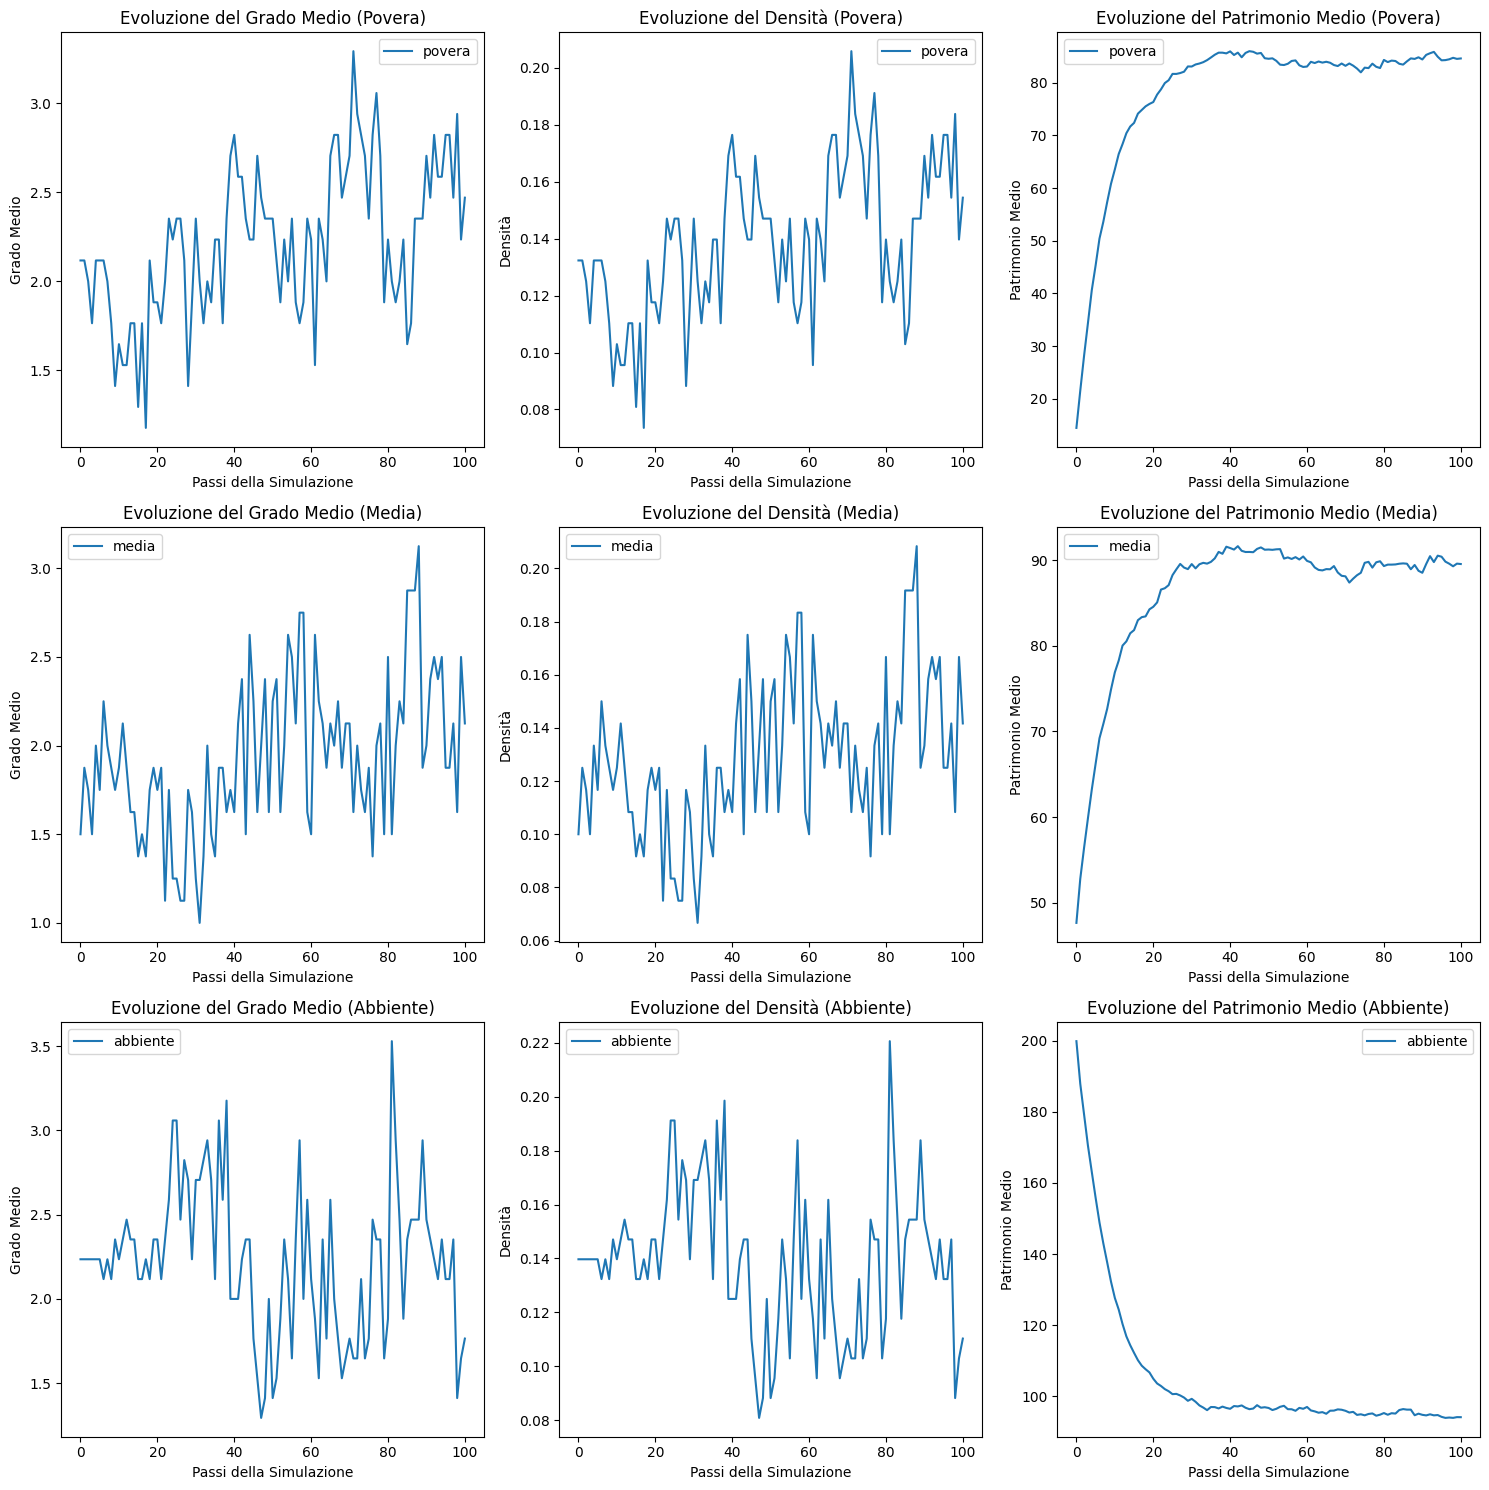

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Parametri della simulazione
num_nodes_initial = 50
num_steps = 100
prob_new_edge = 0.05
prob_remove_edge = 0.01
tax_rate = 0.1
work_income_mean = 10
work_income_std = 2
theft_rate = 0.01
loan_rate = 0.05
pareto_alpha = 2.0

# Inizializzazione del grafo e del patrimonio iniziale dei nodi
G = nx.gnp_random_graph(num_nodes_initial, 0.1)
wealth = np.random.pareto(pareto_alpha, num_nodes_initial) * 100
nx.set_node_attributes(G, {i: wealth[i] for i in range(num_nodes_initial)}, 'wealth')

# Funzione per classificare i nodi in fasce
def classify_nodes(G):
    wealth_values = np.array([G.nodes[node]['wealth'] for node in G.nodes()])
    thresholds = np.percentile(wealth_values, [33.3, 66.6])
    classification = {}
    for node in G.nodes():
        if G.nodes[node]['wealth'] < thresholds[0]:
            classification[node] = 'povera'
        elif G.nodes[node]['wealth'] < thresholds[1]:
            classification[node] = 'media'
        else:
            classification[node] = 'abbiente'
    return classification

# Inizializzazione delle metriche per ciascuna fascia
metrics = {'povera': {'avg_degree': [], 'density': [], 'avg_wealth': []},
           'media': {'avg_degree': [], 'density': [], 'avg_wealth': []},
           'abbiente': {'avg_degree': [], 'density': [], 'avg_wealth': []}}

# Funzione per aggiornare le metriche
def update_metrics(G, classification):
    for category in metrics:
        nodes = [node for node in G.nodes() if classification[node] == category]
        subgraph = G.subgraph(nodes)
        if nodes:
            avg_degree = sum(dict(subgraph.degree()).values()) / len(nodes)
            density = nx.density(subgraph)
            avg_wealth = np.mean([G.nodes[node]['wealth'] for node in nodes])
        else:
            avg_degree = density = avg_wealth = 0
        metrics[category]['avg_degree'].append(avg_degree)
        metrics[category]['density'].append(density)
        metrics[category]['avg_wealth'].append(avg_wealth)

# Aggiornamento iniziale delle metriche
classification = classify_nodes(G)
update_metrics(G, classification)

# Simulazione
for step in range(num_steps):
    # Dinamiche economiche
    for node in G.nodes():
        # Lavoro
        work_income = np.random.normal(work_income_mean, work_income_std)
        G.nodes[node]['wealth'] += work_income

        # Furto
        if np.random.rand() < theft_rate:
            target = np.random.choice(G.nodes())
            theft_amount = G.nodes[target]['wealth'] * 0.05
            G.nodes[target]['wealth'] -= theft_amount
            G.nodes[node]['wealth'] += theft_amount

        # Prestito
        if np.random.rand() < loan_rate:
            target = np.random.choice(G.nodes())
            loan_amount = G.nodes[node]['wealth'] * 0.05
            G.nodes[node]['wealth'] -= loan_amount
            G.nodes[target]['wealth'] += loan_amount

        # Tasse
        tax = G.nodes[node]['wealth'] * tax_rate
        G.nodes[node]['wealth'] -= tax

    # Aggiunta e rimozione di archi
    for edge in list(G.edges()):
        if np.random.rand() < prob_remove_edge:
            G.remove_edge(*edge)
    for _ in range(int(prob_new_edge * len(G))):
        node1, node2 = np.random.choice(G.nodes(), 2, replace=False)
        G.add_edge(node1, node2)

    # Classificazione e aggiornamento delle metriche
    classification = classify_nodes(G)
    update_metrics(G, classification)

# Plot delle metriche
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
categories = ['povera', 'media', 'abbiente']
metrics_names = ['avg_degree', 'density', 'avg_wealth']
titles = ['Grado Medio', 'Densità', 'Patrimonio Medio']

for i, category in enumerate(categories):
    for j, metric in enumerate(metrics_names):
        axs[i, j].plot(metrics[category][metric], label=category)
        axs[i, j].set_title(f'Evoluzione del {titles[j]} ({category.capitalize()})')
        axs[i, j].set_xlabel('Passi della Simulazione')
        axs[i, j].set_ylabel(titles[j])
        axs[i, j].legend()

plt.tight_layout()
plt.show()


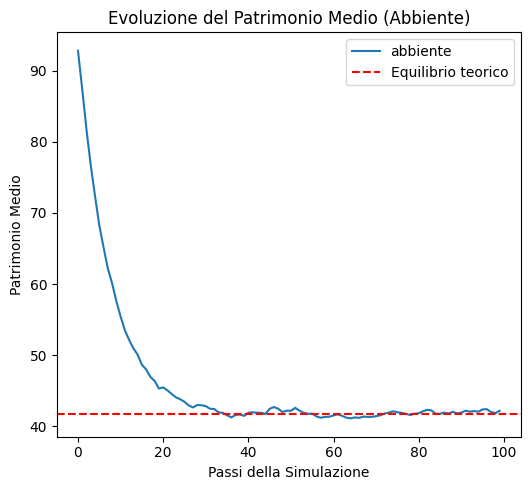

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Parametri della simulazione
num_nodi = 100
num_passi = 100
prob_connessione_iniziale = 0.1

# Parametri economici
reddito_medio = 10
tasso_tasse = 0.1
spese_minime = 5
tasso_furti = 0.02
prob_prestito = 0.1
ammontare_prestito = 5

# Parametri per la formula di equilibrio
mu_E = reddito_medio
tau = tasso_tasse
S = spese_minime
phi = tasso_furti
mu_L = 0  # Assumiamo che i prestiti si bilancino a zero
mu_R = 0  # Assumiamo che le transazioni si bilancino a zero

# Calcolo del patrimonio medio di equilibrio
W_eq = (mu_E + mu_L + mu_R - S) / (tau + phi)

# Funzione per aggiornare il patrimonio dei nodi
def aggiorna_patrimonio(grafo, nodo):
    patrimonio = grafo.nodes[nodo]['patrimonio']
    reddito = np.random.normal(reddito_medio, 2)
    tasse = patrimonio * tasso_tasse
    furti = patrimonio * tasso_furti
    spese = spese_minime
    prestito = 0
    if np.random.rand() < prob_prestito:
        prestito = np.random.choice([-ammontare_prestito, ammontare_prestito])

    nuovo_patrimonio = patrimonio + reddito - tasse - spese - furti + prestito
    grafo.nodes[nodo]['patrimonio'] = max(nuovo_patrimonio, 0)  # Evitiamo patrimoni negativi

# Funzione per gestire nascite e morti
def gestione_nascite_morti(grafo):
    nuovi_nodi = []
    nodi_da_rimuovere = []

    # Verifica nascite e morti
    for nodo in list(grafo.nodes()):
        patrimonio = grafo.nodes[nodo]['patrimonio']

        # Nascite
        if patrimonio > 150:
            nuovo_nodo = max(grafo.nodes()) + 1
            grafo.add_node(nuovo_nodo, patrimonio=100)
            nuovi_nodi.append(nuovo_nodo)

        # Morti
        if patrimonio < spese_minime:
            nodi_da_rimuovere.append(nodo)

    # Aggiungi nuovi nodi
    for nuovo_nodo in nuovi_nodi:
        for _ in range(np.random.randint(1, 5)):  # Connessioni iniziali casuali
            nodo_connessione = np.random.choice(grafo.nodes())
            grafo.add_edge(nuovo_nodo, nodo_connessione)

    # Rimuovi nodi morti
    grafo.remove_nodes_from(nodi_da_rimuovere)

# Creazione del grafo iniziale
grafo = nx.erdos_renyi_graph(num_nodi, prob_connessione_iniziale)
nx.set_node_attributes(grafo, 100, 'patrimonio')  # Impostiamo il patrimonio iniziale

# Simulazione
patrimonio_medio_abbienti = []
for passo in range(num_passi):
    for nodo in list(grafo.nodes()):
        aggiorna_patrimonio(grafo, nodo)

    gestione_nascite_morti(grafo)

    # Calcolo del patrimonio medio degli abbienti
    patrimoni = [grafo.nodes[n]['patrimonio'] for n in grafo.nodes()]
    patrimonio_medio_abbienti.append(np.mean(patrimoni))

# Grafici
plt.figure(figsize=(15, 5))

# Patrimonio medio
plt.subplot(1, 3, 1)
plt.plot(patrimonio_medio_abbienti, label='abbiente')
plt.axhline(W_eq, color='r', linestyle='--', label='Equilibrio teorico')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Patrimonio Medio')
plt.title('Evoluzione del Patrimonio Medio (Abbiente)')
plt.legend()

plt.tight_layout()
plt.show()


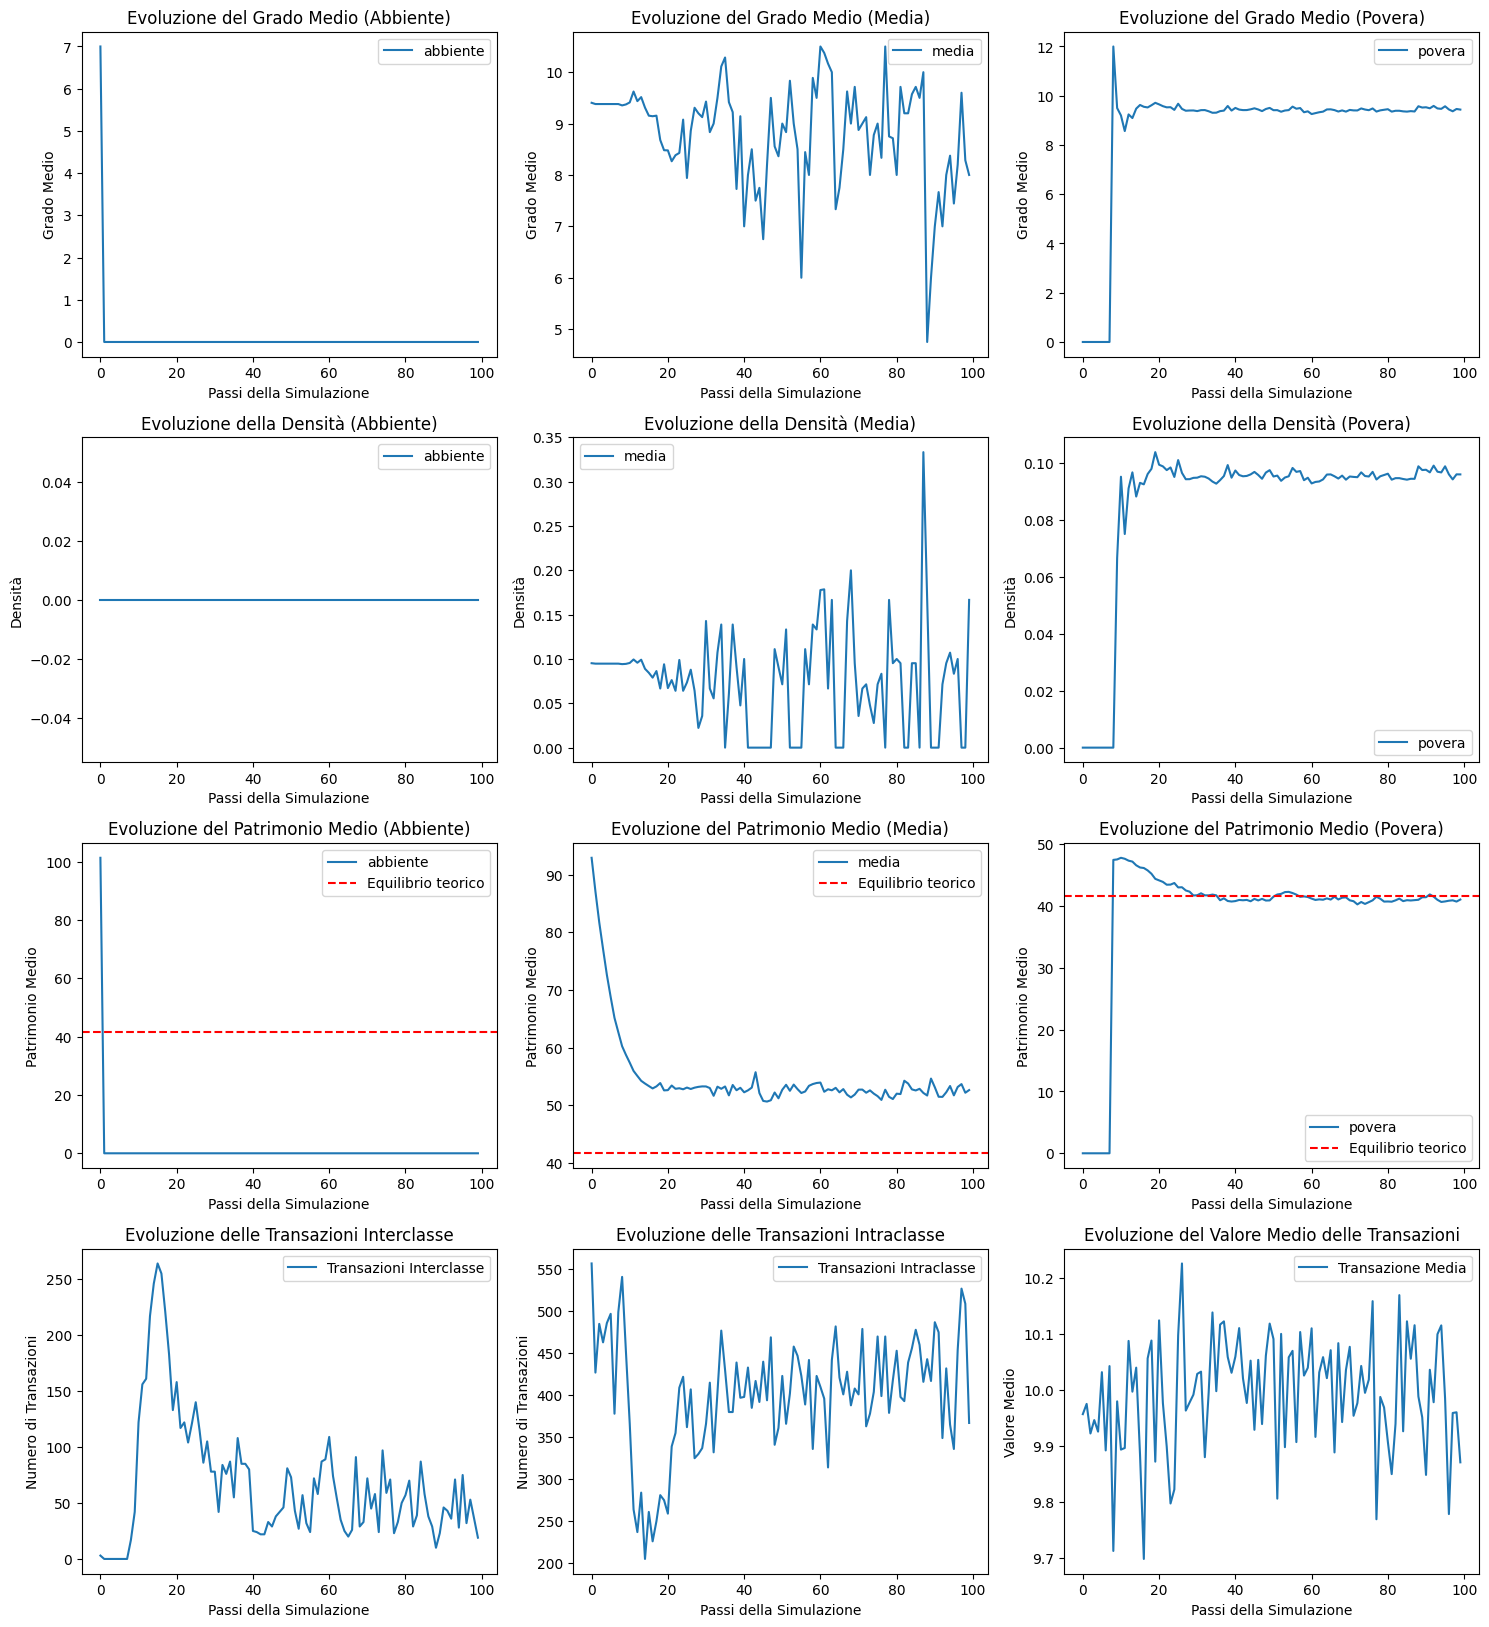

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Parametri della simulazione
num_nodi = 100
num_passi = 100
prob_connessione_iniziale = 0.1

# Parametri economici
reddito_medio = 10
tasso_tasse = 0.1
spese_minime = 5
tasso_furti = 0.02
prob_prestito = 0.1
ammontare_prestito = 5
min_patrimonio = 20  # Limite inferiore per sopravvivenza

# Definizione delle classi economiche
def classe_economica(patrimonio):
    if patrimonio >= 100:
        return 'abbiente'
    elif patrimonio >= 50:
        return 'media'
    else:
        return 'povera'

# Parametri per la formula di equilibrio
mu_E = reddito_medio
tau = tasso_tasse
S = spese_minime
phi = tasso_furti
mu_L = 0  # Assumiamo che i prestiti si bilancino a zero
mu_R = 0  # Assumiamo che le transazioni si bilancino a zero

# Calcolo del patrimonio medio di equilibrio
W_eq = (mu_E + mu_L + mu_R - S) / (tau + phi)

# Funzione per aggiornare il patrimonio dei nodi
def aggiorna_patrimonio(grafo, nodo):
    patrimonio = grafo.nodes[nodo]['patrimonio']
    reddito = np.random.normal(reddito_medio, 2)
    tasse = patrimonio * tasso_tasse
    furti = patrimonio * tasso_furti
    spese = spese_minime
    prestito = 0
    if np.random.rand() < prob_prestito:
        prestito = np.random.choice([-ammontare_prestito, ammontare_prestito])

    nuovo_patrimonio = patrimonio + reddito - tasse - spese - furti + prestito
    grafo.nodes[nodo]['patrimonio'] = max(nuovo_patrimonio, 0)  # Evitiamo patrimoni negativi

# Funzione per gestire nascite e morti
def gestione_nascite_morti(grafo):
    nuovi_nodi = []
    nodi_da_rimuovere = []

    # Verifica nascite e morti
    for nodo in list(grafo.nodes()):
        patrimonio = grafo.nodes[nodo]['patrimonio']

        # Nascite
        if patrimonio > 150:
            nuovo_nodo = max(grafo.nodes()) + 1
            grafo.add_node(nuovo_nodo, patrimonio=100)
            nuovi_nodi.append(nuovo_nodo)

        # Morti
        if patrimonio < min_patrimonio:
            nodi_da_rimuovere.append(nodo)

    # Aggiungi nuovi nodi
    for nuovo_nodo in nuovi_nodi:
        for _ in range(np.random.randint(1, 5)):  # Connessioni iniziali casuali
            nodo_connessione = np.random.choice(grafo.nodes())
            grafo.add_edge(nuovo_nodo, nodo_connessione)

    # Rimuovi nodi morti
    grafo.remove_nodes_from(nodi_da_rimuovere)

# Funzione per calcolare le metriche per ciascuna classe
def calcola_metriche(grafo, classe):
    patrimoni = [grafo.nodes[n]['patrimonio'] for n in grafo.nodes() if classe_economica(grafo.nodes[n]['patrimonio']) == classe]
    if patrimoni:
        grado_medio = np.mean([grafo.degree[n] for n in grafo.nodes() if classe_economica(grafo.nodes[n]['patrimonio']) == classe])
        densita = nx.density(grafo.subgraph([n for n in grafo.nodes() if classe_economica(grafo.nodes[n]['patrimonio']) == classe]))
        patrimonio_medio = np.mean(patrimoni)
    else:
        grado_medio = 0
        densita = 0
        patrimonio_medio = 0
    return grado_medio, densita, patrimonio_medio

# Funzione per calcolare le transazioni
def calcola_transazioni(grafo):
    transazioni_interclasse = 0
    transazioni_intraclasse = 0
    valore_transazioni = []

    for nodo in grafo.nodes():
        patrimonio = grafo.nodes[nodo]['patrimonio']
        classe = classe_economica(patrimonio)

        # Determina le transazioni
        if np.random.rand() < 0.5:  # 50% di probabilità di effettuare una transazione
            for vicino in grafo.neighbors(nodo):
                patrimonio_vicino = grafo.nodes[vicino]['patrimonio']
                classe_vicino = classe_economica(patrimonio_vicino)
                valore_transazione = np.random.normal(reddito_medio, 2)

                if classe == classe_vicino:
                    transazioni_intraclasse += 1
                else:
                    transazioni_interclasse += 1

                valore_transazioni.append(valore_transazione)

    transazione_media = np.mean(valore_transazioni) if valore_transazioni else 0
    return transazioni_interclasse, transazioni_intraclasse, transazione_media

# Creazione del grafo iniziale
grafo = nx.erdos_renyi_graph(num_nodi, prob_connessione_iniziale)
nx.set_node_attributes(grafo, 100, 'patrimonio')  # Impostiamo il patrimonio iniziale

# Simulazione
metriche_abbienti = {'grado_medio': [], 'densita': [], 'patrimonio_medio': []}
metriche_media = {'grado_medio': [], 'densita': [], 'patrimonio_medio': []}
metriche_povera = {'grado_medio': [], 'densita': [], 'patrimonio_medio': []}
transazioni_interclasse = []
transazioni_intraclasse = []
transazioni_medie = []

for passo in range(num_passi):
    for nodo in list(grafo.nodes()):
        aggiorna_patrimonio(grafo, nodo)

    gestione_nascite_morti(grafo)

    grado_medio, densita, patrimonio_medio = calcola_metriche(grafo, 'abbiente')
    metriche_abbienti['grado_medio'].append(grado_medio)
    metriche_abbienti['densita'].append(densita)
    metriche_abbienti['patrimonio_medio'].append(patrimonio_medio)

    grado_medio, densita, patrimonio_medio = calcola_metriche(grafo, 'media')
    metriche_media['grado_medio'].append(grado_medio)
    metriche_media['densita'].append(densita)
    metriche_media['patrimonio_medio'].append(patrimonio_medio)

    grado_medio, densita, patrimonio_medio = calcola_metriche(grafo, 'povera')
    metriche_povera['grado_medio'].append(grado_medio)
    metriche_povera['densita'].append(densita)
    metriche_povera['patrimonio_medio'].append(patrimonio_medio)

    inter, intra, media = calcola_transazioni(grafo)
    transazioni_interclasse.append(inter)
    transazioni_intraclasse.append(intra)
    transazioni_medie.append(media)

# Grafici
plt.figure(figsize=(15, 20))

# Grado medio
plt.subplot(5, 3, 1)
plt.plot(metriche_abbienti['grado_medio'], label='abbiente')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Grado Medio')
plt.title('Evoluzione del Grado Medio (Abbiente)')
plt.legend()

plt.subplot(5, 3, 2)
plt.plot(metriche_media['grado_medio'], label='media')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Grado Medio')
plt.title('Evoluzione del Grado Medio (Media)')
plt.legend()

plt.subplot(5, 3, 3)
plt.plot(metriche_povera['grado_medio'], label='povera')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Grado Medio')
plt.title('Evoluzione del Grado Medio (Povera)')
plt.legend()

# Densità
plt.subplot(5, 3, 4)
plt.plot(metriche_abbienti['densita'], label='abbiente')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Densità')
plt.title('Evoluzione della Densità (Abbiente)')
plt.legend()

plt.subplot(5, 3, 5)
plt.plot(metriche_media['densita'], label='media')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Densità')
plt.title('Evoluzione della Densità (Media)')
plt.legend()

plt.subplot(5, 3, 6)
plt.plot(metriche_povera['densita'], label='povera')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Densità')
plt.title('Evoluzione della Densità (Povera)')
plt.legend()

# Patrimonio medio
plt.subplot(5, 3, 7)
plt.plot(metriche_abbienti['patrimonio_medio'], label='abbiente')
plt.axhline(y=W_eq, color='r', linestyle='--', label='Equilibrio teorico')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Patrimonio Medio')
plt.title('Evoluzione del Patrimonio Medio (Abbiente)')
plt.legend()

plt.subplot(5, 3, 8)
plt.plot(metriche_media['patrimonio_medio'], label='media')
plt.axhline(y=W_eq, color='r', linestyle='--', label='Equilibrio teorico')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Patrimonio Medio')
plt.title('Evoluzione del Patrimonio Medio (Media)')
plt.legend()

plt.subplot(5, 3, 9)
plt.plot(metriche_povera['patrimonio_medio'], label='povera')
plt.axhline(y=W_eq, color='r', linestyle='--', label='Equilibrio teorico')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Patrimonio Medio')
plt.title('Evoluzione del Patrimonio Medio (Povera)')
plt.legend()

# Transazioni interclasse
plt.subplot(5, 3, 10)
plt.plot(transazioni_interclasse, label='Transazioni Interclasse')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Numero di Transazioni')
plt.title('Evoluzione delle Transazioni Interclasse')
plt.legend()

# Transazioni intraclasse
plt.subplot(5, 3, 11)
plt.plot(transazioni_intraclasse, label='Transazioni Intraclasse')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Numero di Transazioni')
plt.title('Evoluzione delle Transazioni Intraclasse')
plt.legend()

# Transazione media
plt.subplot(5, 3, 12)
plt.plot(transazioni_medie, label='Transazione Media')
plt.xlabel('Passi della Simulazione')
plt.ylabel('Valore Medio')
plt.title('Evoluzione del Valore Medio delle Transazioni')
plt.legend()

plt.tight_layout()
plt.show()
